In [50]:
# This Jupyter Notebook contains examples on how to perform forecasts, with varying degrees of complexity
# Pre-requisites:
#     Python 3.X
#     Packages as below

###### Input your access_token here!######
access_token = 'XXXXXXXXXXXX'

import requests
requests.packages.urllib3.disable_warnings() 
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def generate_payload(input_df, input_dict):
    r = json.dumps(input_dict)
    return r

def import_data(infile):
#     Import the time-series representing your historical demand - example CSV provided here:
    input_df = pd.read_csv(infile)
    return input_df

def generate_forecast(access_token, payload):
    # Calling the WasteNot API service with the payload, check the response text
    url = "https://api.bluedotthinking.com/forecast"
    headers = {
        'Content-Type': 'application/json',
        'access_token': access_token
        }

    response = requests.request("POST", url, headers=headers, data=payload, verify=True)
    print ('API response')
    print (response.text)
    print ('-----')
    return response

# Plotting:
# a) Historical demand for the last 30 days, 
# b) Units to be replenished using the replenishment_df - this includes the buffer
def visualise_results(input_df, json_data):

    input_df['timestamp'] = pd.to_datetime(input_df['timestamp'])    

    # Load the output payload into pandas dataframes, converting the timestamp columns into datetimes for easier plotting
    replenishment_df = pd.DataFrame(data={'timestamp':json_data['replenishment_timestamp'],
                                     'replenished_units':json_data['replenishment_units']
                                    })
    replenishment_df['timestamp'] = pd.to_datetime(replenishment_df['timestamp'])

    forecast_df = pd.DataFrame(data={'timestamp': json_data['forecast_timestamp'],
                                     'predicted_demand_units': json_data['predicted_demand_units'],
                                     'optimised_demand_units': json_data['optimised_demand_units'],
                                    })
    forecast_df['timestamp'] = pd.to_datetime(forecast_df['timestamp'])
    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=(20, 6))

    # Specify how our lines should look
    ax.plot(input_df.timestamp[-30:], input_df.demand_units[-30:], color='black', 
            linestyle='-', label='Historical Data: Demand Units')
    ax.plot(forecast_df.timestamp, forecast_df.predicted_demand_units, color='blue', 
            marker="o", linestyle='--', label='Forecast: Predicted Demand Units')
    ax.bar(replenishment_df.timestamp, replenishment_df.replenished_units, color='green', 
    #        marker="o",linestyle='--', 
           label='Optimised Forecast: Buffered Units to Deliver')

    # For a less busy graph, only show the beginning of each week (Monday) as a major label
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    ax.set_xlabel('Datetime')
    ax.set_ylabel('Units')
    ax.set_title('Historical & Optimised Forecast Demand using WasteNot')

    ax.grid(True)
    ax.legend(loc='upper left');

    # Visualising the tables containing the delivered units (optimised), by day
    print ('Replenishment Schedule & Amounts')
    print (replenishment_df)
    print ('-----')
    # Visualising the tables containing the forecasted demand units (unoptimised and optimised), by day
    print ('Forecast Dates & Amounts')
    print (forecast_df)
    print ('-----')

API response
{"status":"success","forecast_timestamp":["2018-08-11"],"predicted_demand_units":[1483.0],"optimised_demand_units":[1696.0],"replenishment_timestamp":["2018-08-11"],"replenishment_units":[1696.0]}
-----
Replenishment Schedule & Amounts
   timestamp  replenished_units
0 2018-08-11             1696.0
-----
Forecast Dates & Amounts
   timestamp  predicted_demand_units  optimised_demand_units
0 2018-08-11                  1483.0                  1696.0
-----


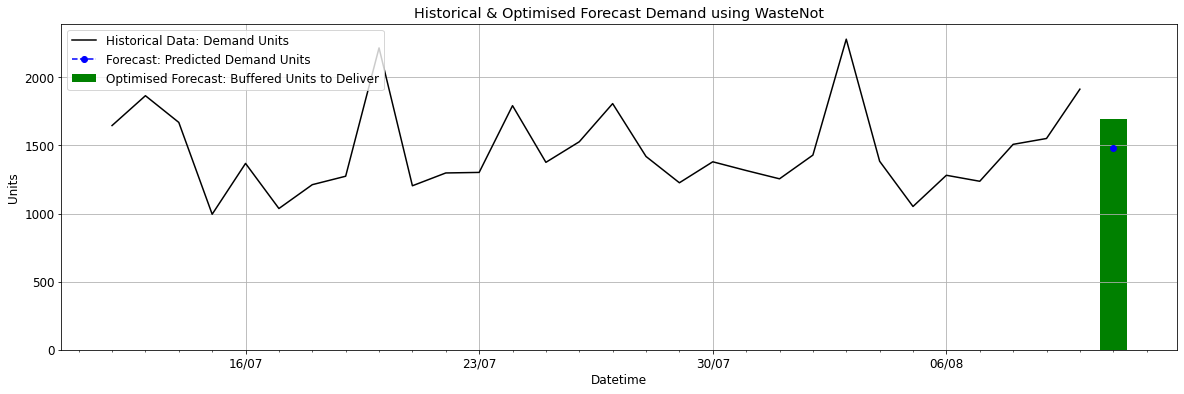

In [51]:
# Generating a payload for this item with
#     unit cost of 1, unit sale-price of 5
#     Shelf Life of 24 hours (86400 seconds)
#     By default, this assumes we will replenish on the next day after the historical data finishes 
#     (i.e. replenish on 2018-08-11)
#     Assumes that there is no stock-on-hand

# Reading in a CSV file and converting to a DataFrame
infile = 'https://raw.githubusercontent.com/alvin-chan/bdt_django_front_end_postgres_mkdocs/master/example_data/bdt_example_input.csv'
input_df = import_data(infile)

unit_cost =1.
unit_sale_price=5.
shelf_life_seconds=86400
input_dict = {'timestamp':list(input_df['timestamp'].values),
              'demand':[int(x) for x in input_df['demand_units'].values],
              "cost": unit_cost, "sale_price": unit_sale_price, 
              "shelf_life_seconds": shelf_life_seconds,
              }
payload = generate_payload(input_df, input_dict)

# Running forecast
response = generate_forecast(access_token, payload)

# Loading the response into JSON format
json_data = json.loads(response.text)

# Visualising results
visualise_results(input_df, json_data)

API response
{"status":"success","forecast_timestamp":["2018-08-11","2018-08-12","2018-08-13"],"predicted_demand_units":[1483.0,1193.0,1397.0],"optimised_demand_units":[1634.0,1314.0,1538.0],"replenishment_timestamp":["2018-08-11"],"replenishment_units":[4486.0]}
-----
Replenishment Schedule & Amounts
   timestamp  replenished_units
0 2018-08-11             4486.0
-----
Forecast Dates & Amounts
   timestamp  predicted_demand_units  optimised_demand_units
0 2018-08-11                  1483.0                  1634.0
1 2018-08-12                  1193.0                  1314.0
2 2018-08-13                  1397.0                  1538.0
-----


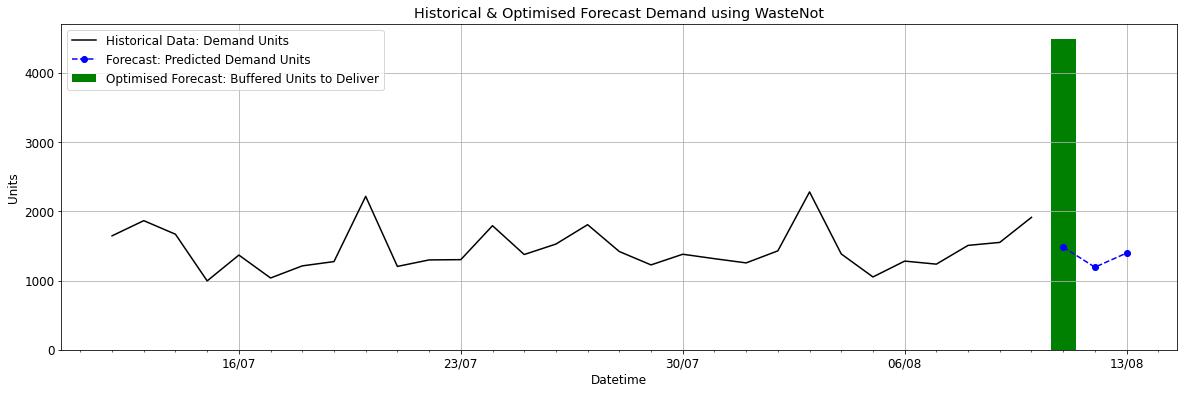

In [52]:
# Generating a payload for this item with
#     unit cost of 1, unit sale-price of 5
#     Shelf Life of 72 hours (259200 seconds)
#     By default, this assumes we will replenish on the next day after the historical data finishes 
#     (i.e. replenish on 2018-08-11)
#     Assumes that there is no stock-on-hand
# The algorithm delivers enough to satisfy the buffered demand for the following 3 days

infile = 'https://raw.githubusercontent.com/alvin-chan/bdt_django_front_end_postgres_mkdocs/master/example_data/bdt_example_input.csv'
input_df = import_data(infile)

unit_cost =1.
unit_sale_price=5.
shelf_life_seconds=259200

input_dict = {'timestamp':list(input_df['timestamp'].values),
              'demand':[int(x) for x in input_df['demand_units'].values],
              "cost": unit_cost, "sale_price": unit_sale_price, 
              "shelf_life_seconds": shelf_life_seconds,
              }
payload = generate_payload(input_df, input_dict)

# Running forecast
response = generate_forecast(access_token, payload)

# Loading the response into JSON format
json_data = json.loads(response.text)

# Visualising results
visualise_results(input_df, json_data)

API response
{"status":"success","forecast_timestamp":["2018-08-11"],"predicted_demand_units":[1483.0],"optimised_demand_units":[1537.0],"replenishment_timestamp":["2018-08-11"],"replenishment_units":[1537.0]}
-----
Replenishment Schedule & Amounts
   timestamp  replenished_units
0 2018-08-11             1537.0
-----
Forecast Dates & Amounts
   timestamp  predicted_demand_units  optimised_demand_units
0 2018-08-11                  1483.0                  1537.0
-----


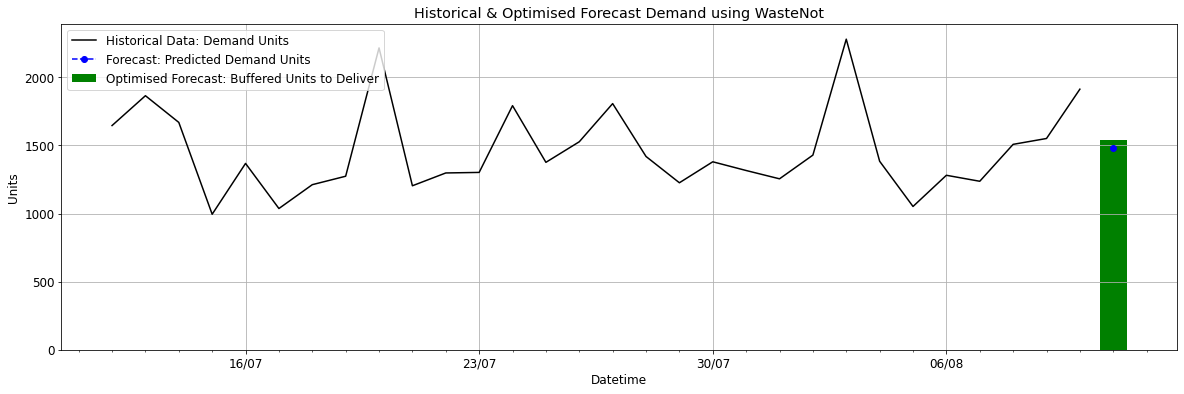

In [53]:
# Generating a payload for this item with
#     unit cost of 1, unit sale-price of 5
#     Shelf Life of 72 hours (259200 seconds)
#     We are stating that daily replenishments occur (i.e. items are replenished/delivered every day of the week)
#     Assumes that there is no stock-on-hand
# The algorithm provides the replenishment amount for the next day (2018-08-11)
# The replenishment amount is substantially lower, given the long shelf-life and replenishments happen regularly!

infile = 'https://raw.githubusercontent.com/alvin-chan/bdt_django_front_end_postgres_mkdocs/master/example_data/bdt_example_input.csv'
input_df = import_data(infile)

unit_cost =1.
unit_sale_price=5.
shelf_life_seconds=259200

input_dict = {'timestamp':list(input_df['timestamp'].values),
              'demand':[int(x) for x in input_df['demand_units'].values],
              "cost": unit_cost, "sale_price": unit_sale_price, 
              "shelf_life_seconds": shelf_life_seconds,
              "replenishment_schedule": 'periodic',
              "replenishment_dayofweek":[0,1,2,3,4,5,6],
              }
payload = generate_payload(input_df, input_dict)

# Running forecast
response = generate_forecast(access_token, payload)

# Loading the response into JSON format
json_data = json.loads(response.text)

# Visualising results
visualise_results(input_df, json_data)

API response
{"status":"success","forecast_timestamp":["2018-08-11","2018-08-12","2018-08-13","2018-08-14","2018-08-15","2018-08-16","2018-08-17","2018-08-18","2018-08-19"],"predicted_demand_units":[1483.0,1193.0,1397.0,1350.0,1448.0,1574.0,2122.0,1491.0,1201.0],"optimised_demand_units":[1537.0,1236.0,1447.0,1399.0,1500.0,1631.0,2198.0,1545.0,1245.0],"replenishment_timestamp":["2018-08-13","2018-08-14","2018-08-15","2018-08-16","2018-08-17","2018-08-18","2018-08-19"],"replenishment_units":[1447.0,1399.0,1500.0,1631.0,2198.0,1545.0,1245.0]}
-----
Replenishment Schedule & Amounts
   timestamp  replenished_units
0 2018-08-13             1447.0
1 2018-08-14             1399.0
2 2018-08-15             1500.0
3 2018-08-16             1631.0
4 2018-08-17             2198.0
5 2018-08-18             1545.0
6 2018-08-19             1245.0
-----
Forecast Dates & Amounts
   timestamp  predicted_demand_units  optimised_demand_units
0 2018-08-11                  1483.0                  1537.0
1 2018

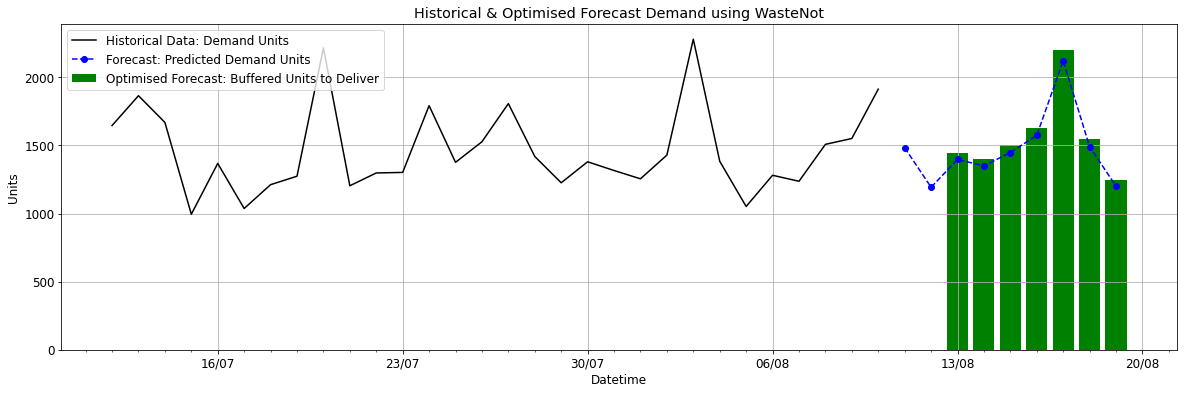

In [54]:
# Generating a payload for this item with
#     unit cost of 1, unit sale-price of 5
#     Shelf Life of 72 hours (259200 seconds)
#     Daily replenishments occur (i.e. items are replenished/delivered every day of the week)
#     We're asking the system to give us the replenishment amounts for the every day of the following week (2018-08-13 to 2018-08-19)
#     Assumes that there is no stock-on-hand
# The algorithm provides the replenishment amount for the next day (2018-08-13 to 2018-08-19)

infile = 'https://raw.githubusercontent.com/alvin-chan/bdt_django_front_end_postgres_mkdocs/master/example_data/bdt_example_input.csv'
input_df = import_data(infile)

unit_cost =1.
unit_sale_price=5.
shelf_life_seconds=259200

input_dict = {'timestamp':list(input_df['timestamp'].values),
              'demand':[int(x) for x in input_df['demand_units'].values],
              "cost": unit_cost, "sale_price": unit_sale_price, 
              "shelf_life_seconds": shelf_life_seconds,
              "replenishment_schedule": 'periodic',
              "replenishment_dayofweek":[0,1,2,3,4,5,6],
              "forecast_start_datetime":'2018-08-13',
              "forecast_end_datetime":'2018-08-19',
              
              }
payload = generate_payload(input_df, input_dict)

# Running forecast
response = generate_forecast(access_token, payload)

# Loading the response into JSON format
json_data = json.loads(response.text)

# Visualising results
visualise_results(input_df, json_data)

API response
{"status":"success","forecast_timestamp":["2018-08-11","2018-08-12","2018-08-13","2018-08-14"],"predicted_demand_units":[1483.0,1193.0,1397.0,1350.0],"optimised_demand_units":[1616.0,1300.0,1522.0,1471.0],"replenishment_timestamp":["2018-08-12"],"replenishment_units":[4293.0]}
-----
Replenishment Schedule & Amounts
   timestamp  replenished_units
0 2018-08-12             4293.0
-----
Forecast Dates & Amounts
   timestamp  predicted_demand_units  optimised_demand_units
0 2018-08-11                  1483.0                  1616.0
1 2018-08-12                  1193.0                  1300.0
2 2018-08-13                  1397.0                  1522.0
3 2018-08-14                  1350.0                  1471.0
-----


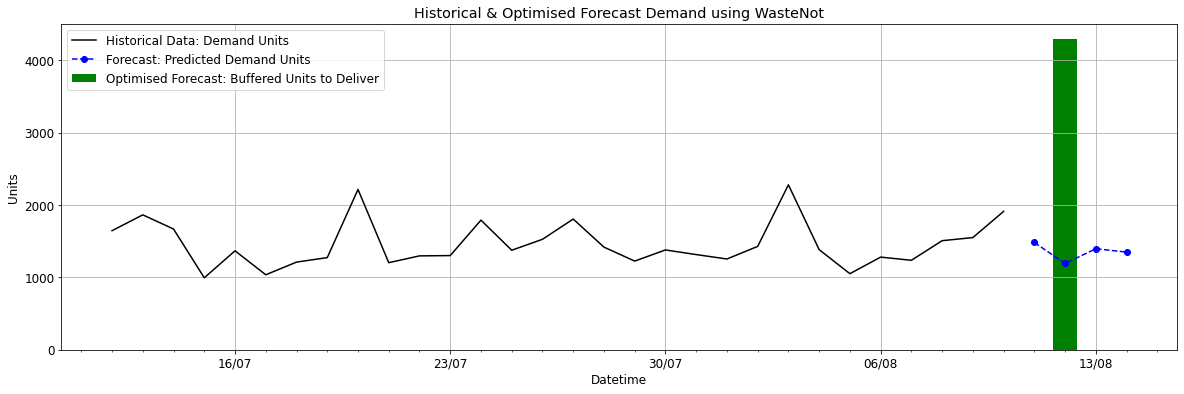

In [55]:
# Generating a payload for this item with
#     unit cost of 1, unit sale-price of 5
#     Shelf Life of 72 hours (259200 seconds)
#     We are stating that periodic replenishments occur 
#         (in thise case, items are replenished/delivered every Weds, Friday and Sunday each week
#     Assumes that there is no stock-on-hand
# The algorithm provides the replenishment amount for the next replenishment point (Sunday, 2018-08-12)
# The replenishment amount covers demand for Sunday, Monday and Tues (expecting the next replenishment on Weds)

infile = 'https://raw.githubusercontent.com/alvin-chan/bdt_django_front_end_postgres_mkdocs/master/example_data/bdt_example_input.csv'
input_df = import_data(infile)

unit_cost =1.
unit_sale_price=5.
shelf_life_seconds=259200

input_dict = {'timestamp':list(input_df['timestamp'].values),
              'demand':[int(x) for x in input_df['demand_units'].values],
              "cost": unit_cost, "sale_price": unit_sale_price, 
              "shelf_life_seconds": shelf_life_seconds,
              "replenishment_schedule": 'periodic',
              "replenishment_dayofweek":[2,4,6],
              }
payload = generate_payload(input_df, input_dict)

# Running forecast
response = generate_forecast(access_token, payload)

# Loading the response into JSON format
json_data = json.loads(response.text)

# Visualising results
visualise_results(input_df, json_data)

API response
{"status":"success","forecast_timestamp":["2018-08-11","2018-08-12","2018-08-13","2018-08-14","2018-08-15","2018-08-16","2018-08-17"],"predicted_demand_units":[1483.0,1193.0,1397.0,1350.0,1448.0,1574.0,2122.0],"optimised_demand_units":[1569.0,1262.0,1477.0,1428.0,1531.0,1665.0,2244.0],"replenishment_timestamp":["2018-08-13","2018-08-15"],"replenishment_units":[2905.0,5440.0]}
-----
Replenishment Schedule & Amounts
   timestamp  replenished_units
0 2018-08-13             2905.0
1 2018-08-15             5440.0
-----
Forecast Dates & Amounts
   timestamp  predicted_demand_units  optimised_demand_units
0 2018-08-11                  1483.0                  1569.0
1 2018-08-12                  1193.0                  1262.0
2 2018-08-13                  1397.0                  1477.0
3 2018-08-14                  1350.0                  1428.0
4 2018-08-15                  1448.0                  1531.0
5 2018-08-16                  1574.0                  1665.0
6 2018-08-17   

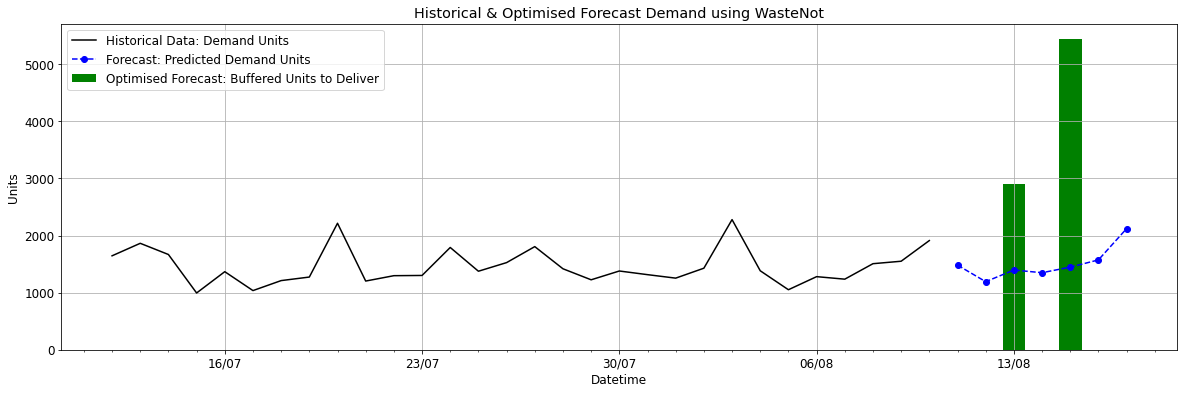

In [56]:
# Generating a payload for this item with
#     unit cost of 1, unit sale-price of 5
#     Shelf Life of 72 hours (259200 seconds)
#     Replenishments occur on specific dates in the future (2018-08-13 & 2018-08-15)
#     Assumes that there is no stock-on-hand
# The algorithm provides the replenishment amount for the provided replenishment points (2018-08-13 and 2018-08-15)
# The replenishment amount covers demand over 2018-08-13 to 2018-08-17 (reflecting the item's 3 day shelf life)

infile = 'https://raw.githubusercontent.com/alvin-chan/bdt_django_front_end_postgres_mkdocs/master/example_data/bdt_example_input.csv'
input_df = import_data(infile)

unit_cost =1.
unit_sale_price=5.
shelf_life_seconds=259200

input_dict = {'timestamp':list(input_df['timestamp'].values),
              'demand':[int(x) for x in input_df['demand_units'].values],
              "cost": unit_cost, "sale_price": unit_sale_price, 
              "shelf_life_seconds": shelf_life_seconds,
              "replenishment_schedule": 'custom_dates',
              "future_replenishment_datetimes":['2018-08-13','2018-08-15']
              }
payload = generate_payload(input_df, input_dict)

# Running forecast
response = generate_forecast(access_token, payload)

# Loading the response into JSON format
json_data = json.loads(response.text)

# Visualising results
visualise_results(input_df, json_data)

API response
{"status":"success","forecast_timestamp":["2018-08-11","2018-08-12","2018-08-13","2018-08-14","2018-08-15","2018-08-16","2018-08-17","2018-08-18","2018-08-19"],"predicted_demand_units":[1483.0,1193.0,1397.0,1350.0,1448.0,1574.0,2122.0,1491.0,1201.0],"optimised_demand_units":[1581.0,1272.0,1489.0,1439.0,1543.0,1678.0,2262.0,1589.0,1280.0],"replenishment_timestamp":["2018-08-11","2018-08-12","2018-08-13","2018-08-14","2018-08-15","2018-08-16","2018-08-17","2018-08-18","2018-08-19"],"replenishment_units":[0.0,755.0,1489.0,1439.0,1543.0,1678.0,2262.0,1589.0,1280.0]}
-----
Replenishment Schedule & Amounts
   timestamp  replenished_units
0 2018-08-11                0.0
1 2018-08-12              755.0
2 2018-08-13             1489.0
3 2018-08-14             1439.0
4 2018-08-15             1543.0
5 2018-08-16             1678.0
6 2018-08-17             2262.0
7 2018-08-18             1589.0
8 2018-08-19             1280.0
-----
Forecast Dates & Amounts
   timestamp  predicted_dema

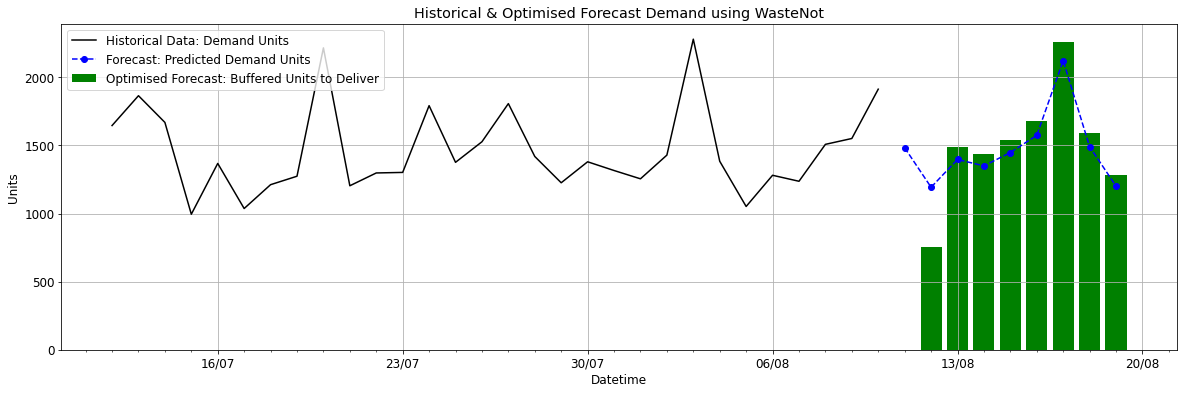

In [59]:
# Generating a payload for this item with
#     unit cost of 1, unit sale-price of 5
#     Shelf Life of 48 hours (172800 seconds)
#     Daily replenishments occur (i.e. items are replenished/delivered every day of the week)
#     We're asking the system to give us the replenishment amounts for the every day of the following 9 days (2018-08-11 to 2018-08-19)
#     In thie example, there are 2000 units in Stock-on-hand (500 expiring 2018-08-12, 1500 expiring 2018-08-13)
# The algorithm provides the replenishment amount for the next day (2018-08-11 to 2018-08-19)
# The replenishment amounts are dramatically reduced on the first 2 days 
#     (0 units replenished on 2018-08-11; 755 units on 2018-08-12)
#     to reflect the stock-on-hand and shelf-life


infile = 'https://raw.githubusercontent.com/alvin-chan/bdt_django_front_end_postgres_mkdocs/master/example_data/bdt_example_input.csv'
input_df = import_data(infile)

unit_cost =1.
unit_sale_price=5.
shelf_life_seconds=172800

input_dict = {'timestamp':list(input_df['timestamp'].values),
              'demand':[int(x) for x in input_df['demand_units'].values],
              "cost": unit_cost, "sale_price": unit_sale_price, 
              "shelf_life_seconds": shelf_life_seconds,
              "replenishment_schedule": 'periodic',
              "replenishment_dayofweek":[0,1,2,3,4,5,6],
              "forecast_start_datetime":'2018-08-11',
              "forecast_end_datetime":'2018-08-19',
              "stock_expiry_datetimes":['2018-08-12','2018-08-13'],
              "stock_available_units":[500,1500],              
              }
payload = generate_payload(input_df, input_dict)

# Running forecast
response = generate_forecast(access_token, payload)

# Loading the response into JSON format
json_data = json.loads(response.text)

# Visualising results
visualise_results(input_df, json_data)